# Analysis of Wikipedia Network
Elliot Williams<br>March 24, 2018<br>Web Scraping w. Prof. Oleinikov

## Background

Before this point, I ran `extractHTML.sh` on the entire set of Wikipedia articles, accessible from the [Internet Archive](https://archive.org/search.php?query=subject%3A%22enwiki%22%20AND%20subject%3A%22data%20dumps%22%20AND%20collection%3A%22wikimediadownloads%22&and[]=subject%3A%22Wikipedia%22), resulting in 54 files representing the adjacency list of the entire Wikipedia network (in which articles are nodes, hyperlinks directed edges).

## Analyzing the Results

Firstly, I want to plot the out degree distribution of the Wikipedia network, as well as see some instances of high-outdegree nodes.

Let's start by figuring out the number of nodes and their associated degrees, which we do by applying some smart regex and newline counts on all of our result files.

(**Sidenote**: I'm running this on the CS kurtz server -- it takes forever to run on my laptop -- and I'm using [ray](http://ray.readthedocs.io/en/latest/) to run some of my code -- ie `getOutdegs` -- in parallel without having to implement it in parallel myself)

In [1]:
%%capture
%load_ext rpy2.ipython
# This code just imports python libraries and initializes ray
import ray
import re
import glob
from functools import reduce
import pandas as pd
ray.init()

In [2]:
# Gets list of all adjacency list files
file_list = glob.glob("./PreviousResults/Jan202018/*.dat")

'''
The following function reads in a given adjacency list file and returns
a list containing elements of format (articleName, outdegree).
'''
@ray.remote
def getOutdegs(filename):
    f = open(filename)

    # Parses out HTTP links --> just in case any got through the initial search
    # Also, some of the links contain '#' pointers to specific parts of an article 
    # -- let's remove these (both done in one loop for speed purposes)
    lines = [re.sub("#.*", "", line.strip()) for line in f if 
             not re.search("https?:\/\/", line)]

    # This list contains the line number associated with all article titles
    # (These, in my schema, are the lines starting with >>>>)
    t_indices = [i for i in range(len(lines)) if re.search(">>>>", lines[i])]
    
    # This list contains all titles in this file
    titles   = [re.sub(">>>>", "", lines[i]) for i in t_indices]
    
    # Here, we use some smart regex and line counting to derive all of the outdegrees of articles
    # (by counting the lines between each instance of '>>>>', and dealing with the edge case of the end of the file)
    out_degs = [t_indices[i+1] - t_indices[i] - 1 
                for i in range(len(t_indices) - 1)] + [len(lines[t_indices[-1]:])]
    t_outdegs = list(zip(titles, out_degs))
    return(t_outdegs)

# Here, we obtain the outdegree list for all of our output files,
# run in parallel using ray
file_results = ray.get([getOutdegs.remote(filename) for filename in file_list])

Now that we have our results for each file, let's combine all of the results together into one dataset we can manage

In [3]:
# Combines all of our results into one list
t_outdegs = reduce(lambda x,y : x + y, file_results)
t_outdegs.sort(key=lambda x: x[1], reverse=True)

In [4]:
# Converts dataset into Pandas DataFrame,
# for later passing the data into R
titles, outdegs = zip(*t_outdegs)
df = pd.DataFrame({"title": titles, "outdeg":outdegs})

## Basic Analysis of Network Structure

Now that we have a dataset consisting of the outdegree of every article on Wikipedia, let's see what the distribution of outdegrees is among all articles, which I do in the next three figures. The code below calculates relevant statistics (ie the mean, median, Q1, Q3, and standard deviation of the Wikipedia outdegrees), and plots them in the three graphs below.

Let's start with a box-and-whiskers plot of the outdegree, excluding outliers (ie high degree articles)

In [5]:
%%capture
%%R -i df -o counts
library(dplyr)
library(ggplot2)

# Here, we produce a frequency table for Wikipedia article outdegrees
counts <- df %>%
group_by(outdeg) %>%
summarize(n=n()) %>%
arrange(desc(n))

# ... and calculate the standard deviation 
sd_value <- sd(df$outdeg)
# ... and the cumulative frequency of the dataset
counts$cum_n <- cumsum(counts$n)

[1] "The average outdegree of an article on Wikipedia is 22.804"
[1] "The median outdegree of an article on Wikipedia is 11"
[1] "The standard deviation of an article's outdegree on Wikipedia is 53.49"


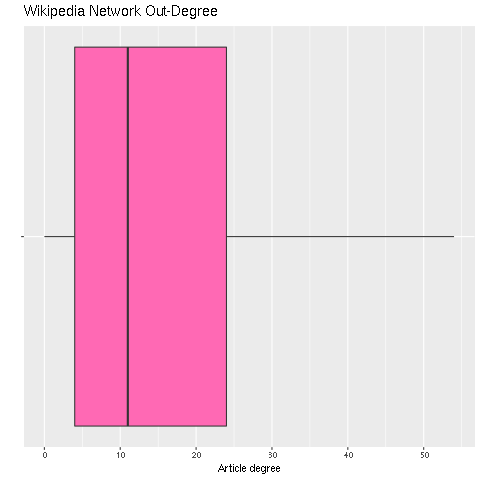

In [6]:
%%R -i counts

# Mean calculating logic
mean <- sum(counts$outdeg * counts$n) / sum(counts$n)
mean <- round(mean, digits=3)
print(paste("The average outdegree of an article on Wikipedia is", mean, sep=" "))

# Q1, Median, Q3 calculating logic
median_index <- as.integer(sum(counts$n)/2)
q1_index <- as.integer(sum(counts$n)/4)
q3_index <- as.integer(median_index + q1_index)
q1_value <- min(which(counts$cum_n > q1_index))
median_value <- min(which(counts$cum_n > median_index))
print(paste("The median outdegree of an article on Wikipedia is", median_value)) 
q3_value <- min(which(counts$cum_n > q3_index))

# Standard Deviation printing logic
sd_value <- round(sd_value, digits=3)
print(paste("The standard deviation of an article's outdegree on Wikipedia is", sd_value))

# And now we print a box-and-whisker plot of the data, excluding 'outliers'
# (< 1.5 IQR outside of middle 50% of data)
desc_df <- data.frame(t(c(min(counts$outdeg), q1_value, median_value, q3_value, 
  1.5*(q3_value-q1_value) + q3_value )))
names(desc_df) <- c("min", "q1", "med", "q3", "max_iqr")

ggplot(desc_df, aes(x = "", middle= median_value, ymin = min,
                    ymax = max_iqr, lower = q1, upper = q3)) + 
    geom_boxplot(stat = "identity", fill="hotpink") + coord_flip() +
    labs(y="Article degree", x="", title="Wikipedia Network Out-Degree")  +
    scale_y_continuous(breaks  = c(0, 10.,20.,30.,40.,50.))


Let's also plot the outdegree of small-outdegree articles as a regular frequency line graph

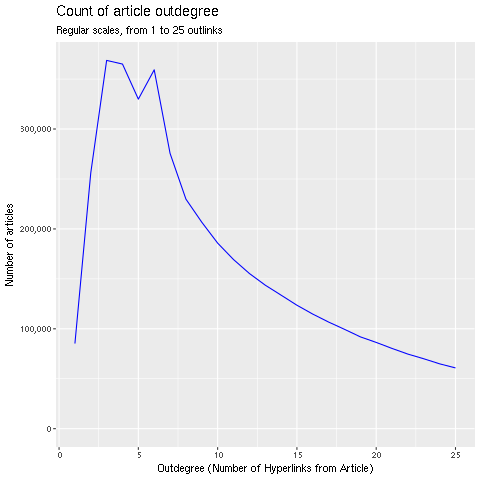

In [7]:
%%R -i counts

print(ggplot(counts, aes(x=outdeg, y=n)) + geom_line(color="blue") +
labs(x="Outdegree (Number of Hyperlinks from Article)",
     y="Number of articles",
     title="Count of article outdegree",
     subtitle="Regular scales, from 1 to 25 outlinks") + xlim(1,25) +
scale_y_continuous(labels = scales::comma))

We can see from the above two graphs that the Wikipedia articles strongly skew right with respect to the number of links per page.

Now, let's see what distribution the outdegree of articles follows asymptotically...

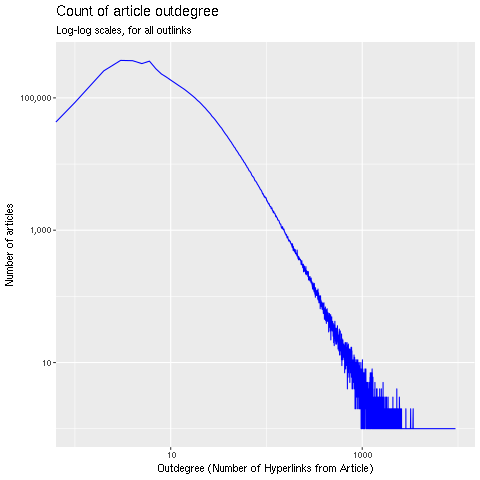

In [8]:
%%R -i counts
ggplot(counts, aes(x=outdeg, y=n)) + geom_line(color="blue") +
labs(x="Outdegree (Number of Hyperlinks from Article)",
     y="Number of articles",
     title="Count of article outdegree",
     subtitle="Log-log scales, for all outlinks") + 
scale_y_continuous(labels = scales::comma, trans="log10") +
scale_x_continuous(trans="log10")

Past 6 links, the number of articles with x links ($x>6$) monotonically decreases, and as you can see, the outdegree (when $\text{outdegree} > 20$ or so) is log-log linear in terms of outdegree, and so can be said to follow a power law distribution with respect to outdegree. Our Wikipedia network can be described as [Scale-Free](https://en.wikipedia.org/wiki/Scale-free_network).

## What types of articles have high outdegree?

In [9]:
# List of highest outdegree articles
t_outdegs[1:30]

[('Rosters of the top basketball teams in European club competitions', 9068),
 ('List of film director and actor collaborations', 8861),
 ('Timeline of heavy metal and hard rock music', 8333),
 ('List of stage names', 6646),
 ('List of years in jazz', 6490),
 ('List of dialling codes in Germany', 6381),
 ('List of male mixed martial artists', 6300),
 ('List of performances on Top of the Pops', 6249),
 ('List of OMIM disorder codes', 6210),
 ('List of populated places in Bosnia and Herzegovina', 6007),
 ('List of cities, towns and villages in Kerman Province', 5853),
 ('List of protected areas of China', 5842),
 ('List of people from Texas', 5827),
 ('Index of Telangana-related articles', 5778),
 ('Index of Andhra Pradesh-related articles', 5698),
 ('List of cities, towns and villages in Sistan and Baluchestan Province',
  5606),
 ('Alphabetical list of comunes of Italy', 5492),
 ('List of foreign football players in Serbia', 5395),
 ('Index of India-related articles', 5315),
 ('List of

We can see that lists dominate high-outdegree Wikipedia articles, which is interesting because some of these articles are rendered using templates (ie directly copying other articles), which isn't represented within the January 20th, 2018 Wikipedia extraction I did (those links were thrown away).

In the first results above, we also see a some of 'List of [X University]' people entries. We could use the outdegree of these articles a as proxy measure of universities with interesting / noteworthy alumni. I do that below (scroll down to later in the document to see this).

## Non-List High Outdegree Wikipedia Articles

Having said that, I want to see what other Wikipedia articles have high degree that aren't Lists or Indices. So, I filter them out below...

In [10]:
f_t_outdegs = list(filter(lambda x : not re.search("((L|l)ist)|(Index)|(Timeline)", x[0]), t_outdegs))
f_t_outdegs[1:30]

[('2016 in the United States', 3927),
 ('2018 in sports', 3747),
 ('Italian Athletics Championships', 3615),
 ('Culture of the United Kingdom', 3412),
 ('Flora of Lebanon', 3099),
 ('2016 in aviation', 3066),
 ('1979', 2968),
 ('2017 in the United States', 2945),
 ('Agrilus', 2895),
 ('1989', 2855),
 ('1945', 2767),
 ('2015 in aviation', 2737),
 ('The Neptunes production discography', 2713),
 ('1990', 2627),
 ('1991', 2533),
 ('Phyllosticta', 2530),
 ('1992', 2425),
 ('1970', 2415),
 ('1972', 2385),
 ('Plants of the Reserva de la Biosfera Manantlan', 2383),
 ('1986', 2358),
 ('1942', 2345),
 ('Scientific phenomena named after people', 2343),
 ('1988', 2341),
 ('1944', 2341),
 ('1973', 2339),
 ('1980', 2334),
 ('Roads in Malta', 2297),
 ('1993', 2296)]

Now we see that year articles tend to dominate high-degree articles. Let's try excluding these articles, and let's graph the results

In [53]:
f_y_t_outdegs = list(filter(lambda x : not re.search("[0-9]{4}", x[0]), f_t_outdegs))
def outdeg_to_df(t_outdegs, num_results):
    titles, outdegs = zip(*t_outdegs[:num_results+1])
    df = pd.DataFrame({"title":titles, "outdeg":outdegs})
    return(df)

f_y_df = outdeg_to_df(f_y_t_outdegs, 30)

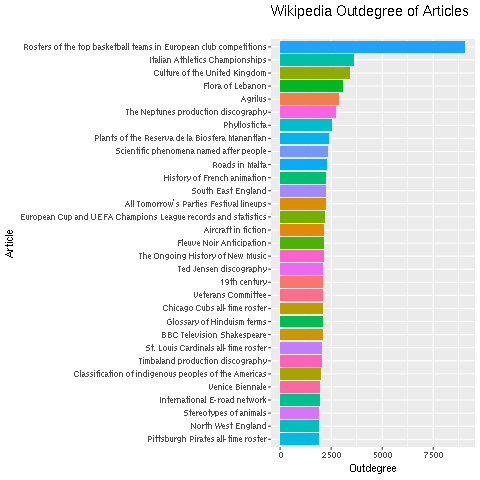

In [57]:
%%R -i f_y_df
library(ggplot2)
library(dplyr)
    
plot_t_df <- function(f_y_df, title_label, title, subtitle="") {
    orig_title <- factor(f_y_df$title)
    f_y_df$title <- factor(f_y_df$title, levels=f_y_df$title[order(f_y_df$outdeg)])
    ggplot(f_y_df, aes(x=title, y=outdeg, fill=orig_title)) + geom_bar(stat="identity") +
    coord_flip() + theme(legend.position="") +
    labs(title=title,
     y = "Outdegree",
     x = title_label,
     subtitle=subtitle)
}    

plot_t_df(f_y_df, "Article", "Wikipedia Outdegree of Articles")


I'm a fan of how esoteric these article titles are beginning to look. It's also fascinating that something as (to me) boring as European basketball has the longest Wikipedia article that isn't a list, index or year. 

These articles also raise several new areas of inquiry, though (ie **Discography** and **All-Time Baseball Rosters**, see below)

## Analysis of University Alumni Lists

Now, let's filter out our dataset to analyze only lists of university/college alumni.

In [61]:
uni_t_outdegs = list(filter(lambda x : re.search("List.*(University|College).*(people|alumni)", x[0]), t_outdegs))

How many of these articles do we have?

In [14]:
len(uni_t_outdegs)

689

And what do high degree articles look like?

In [15]:
uni_t_outdegs[1:20]

[('List of University of Pennsylvania people', 4175),
 ('List of Columbia College people', 3575),
 ('List of University of Toronto people', 2924),
 ('List of Wesleyan University people', 2486),
 ('List of University of Cambridge people', 2351),
 ('List of Duke University people', 2259),
 ('List of Columbia University alumni', 2196),
 ('List of Columbia University alumni and attendees', 2121),
 ('List of Yale University people', 2045),
 ('List of Brown University people', 2040),
 ('List of Columbia University people in politics, military and law', 1967),
 ('List of Stanford University people', 1880),
 ('List of University of Wisconsin–Madison people', 1876),
 ('List of University of Southern California people', 1842),
 ('List of University of California, Los Angeles people', 1737),
 ('List of University of Florida alumni', 1603),
 ('List of University of Minnesota people', 1588),
 ('List of Williams College people', 1570),
 ('List of Northwestern University alumni', 1533)]

Now, let's try to get rid of the "in", "with" and "and" results, which will only serve to double count people.

**Note: this is an imperfect assumption, due to the fact that templates are used in some 'List' articles. For example, this excludes the vast majority of Harvard/Dartmouth links, because alumni lists for those schools are divided up into multiple articles. I will spend some more time manually combining this dataset in future.**

**That, or I will edit my parsing workflow to expand these templates**

In [62]:
uni_t_outdegs_filt = list(filter(lambda x : not re.search("( in )|( with )|( and )", x[0]), uni_t_outdegs))
uni_df = outdeg_to_df(uni_t_outdegs_filt, 1000)

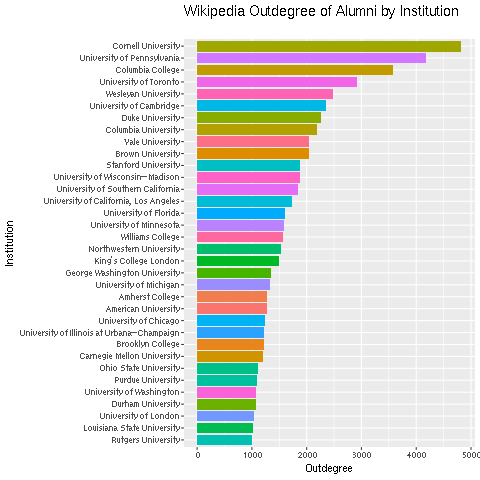

In [65]:
%%R -i uni_df
library(ggplot2)
library(dplyr)

# I'm making the arbitrary decision to graph only institutions with an outdegree > 1000
uni_df <- filter(uni_df, outdeg > 1000) %>%
    mutate(title=gsub("List of ", "", title),
           title=gsub(" (people|alumni)", "", title))
    
plot_t_df(uni_df, "Institution", "Wikipedia Outdegree of Alumni by Institution")

In [68]:
NESCAC_schools = ["Amherst College", "Wesleyan University", "Bowdoin College",
                  "Colby College"  , "Connecticut College", "Hamilton College",
                  "Middlebury College", "Trinity College \(Connecticut\)", "Tufts University",
                  "Williams College"]
nescac_t_outdegs = []
for school in NESCAC_schools:
    nescac_t_outdegs += list(filter(lambda x : re.search("List of " +school, x[0]), uni_t_outdegs))
    
nes_df = outdeg_to_df(nescac_t_outdegs, 10000)

By looking at the Colby College website, I see that their alumni list is divided up into multiple articles, and the `List of Colby College alumni` article is generated via templates. So, I exclude this school, pending a workaround of the template generation issue. All other schools are fair for comparison. So, let's graph each institution's article outdegree.

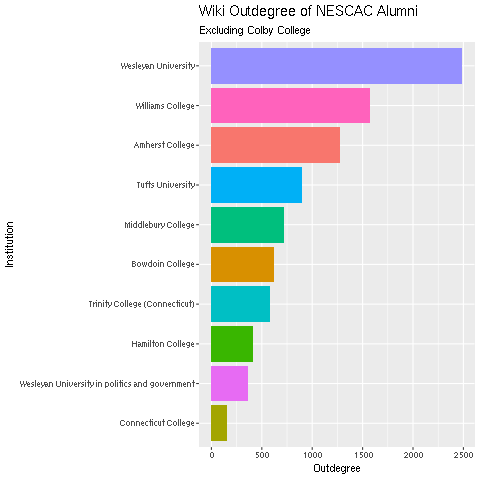

In [72]:
%%R -i nes_df

library(ggplot2)

nes_df <- nes_df %>% filter(title != "List of Colby College alumni")

nes_df <- nes_df %>% mutate(title=gsub("List of ", "", title),
           title=gsub(" (people|alumni)", "", title))

plot_t_df(nes_df, "Institution", "Wiki Outdegree of NESCAC Alumni", "Excluding Colby College")

As you can see, of all NESCAC schools with data, Wesleyan has the most Wikipedia links on its alumni page. My three interpretations of this are:

1. That we are a school with cool, noteworthy alumni (my personal favorite interpretation)
2. That we punch above our weight when it comes to editing our Wikipedia page (ie more Wikipedians went to / care about Wesleyan)
3. Michael Roth spends his nights editing our Wikipedia page

I'm vaguely interested in repeating the same analysis for Ivy League institutions...

In [73]:
Ivy_Schools = ["Brown University", "Columbia University", "Cornell University",
               "Dartmouth College", "Harvard University", "University of Pennsylvania",
               "Princeton University", "Yale University"]
ivy_t_outdegs = []
for school in Ivy_Schools:
    ivy_t_outdegs += list(filter(lambda x : re.search("(?<=List of) " + school + " (people|alumni)(?=)", x[0]), uni_t_outdegs))
ivy_t_outdegs = list(filter(lambda x : not re.search("\(.*\)", x[0]), ivy_t_outdegs))
ivy_t_outdegs = list(filter(lambda x : not re.search("Columbia University people", x[0]),
                            ivy_t_outdegs))
ivy_df = outdeg_to_df(ivy_t_outdegs, len(Ivy_Schools))

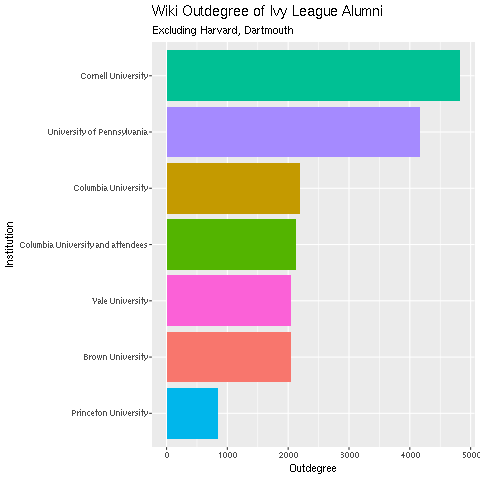

In [76]:
%%R -i ivy_df
library(ggplot2)
# The same issue of few links due to templates applies to Harvard and Dartmouth
# So, let's filter them out...
ivy_df <- ivy_df %>% filter(title != "List of Dartmouth College alumni", title!= "List of Harvard University people")

ivy_df <- ivy_df %>% mutate(title=gsub("List of ", "", title),
           title=gsub(" (people|alumni)", "", title))
plot_t_df(ivy_df, "Institution", "Wiki Outdegree of Ivy League Alumni", "Excluding Harvard, Dartmouth")

## Wikipedian Interest by Year

Another interesting question posed above is which years are more 'interesting', gauged by the number of Wikipedia-facing links present on the Wikipedia page of each year.

In [22]:
# Filtering out only numeric articles with title length 4
date_t_outdegs = list(filter(lambda x : re.search("[0-9]{4}", x[0]), f_t_outdegs))
date_t_outdegs = list(filter(lambda x : len(x[0]) == 4, date_t_outdegs))

# But we only care about years... so we filter all above 2018 and below 1700
date_t_outdegs = [x for x in date_t_outdegs if int(x[0]) > 1700 and int(x[0])<2019]


In [23]:
print("There are {} year articles between 1700 and 2018".format(len(date_t_outdegs)))
date_t_outdegs.sort(reverse=True)
date_t_outdegs[1:5]

There are 318 year articles between 1700 and 2018


[('2017', 1419), ('2016', 1151), ('2015', 1135), ('2014', 851)]

Now that we've filtered out all non-date articles, let's graph each article's outdegree by the year it is associated with

In [24]:
d_titles, d_outdegs = zip(*date_t_outdegs)
d_titles = [int(x) for x in d_titles]
date_df = pd.DataFrame({"year": d_titles, "outdeg":d_outdegs})

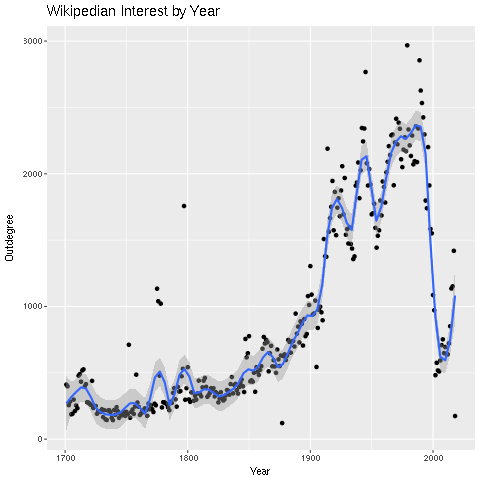

In [25]:
%%R -i date_df

ggplot(date_df, aes(x=year, y=outdeg)) + geom_point() + geom_smooth(span=0.1, method='loess') +
    labs(title="Wikipedian Interest by Year", x="Year", y="Outdegree")

The above graph is a good proxy measure for how historically interesting various years were, based on the number of Wikipedia articles written about events in each given year. I find it fascinating to see how the graph peaks during World War I, World War II, and the height of the Cold War.

## Discography Analysis

Recall that above, we saw that some of the highest degree articles were about discography. Let's graph the highest degree articles on the subject...

In [45]:
disco_outdegs = [x for x in f_y_t_outdegs if re.search("discography", x[0])]
d_titles, d_outdegs = zip(*disco_outdegs[0:30])
disco_df = pd.DataFrame({"title":d_titles, "outdeg":d_outdegs})

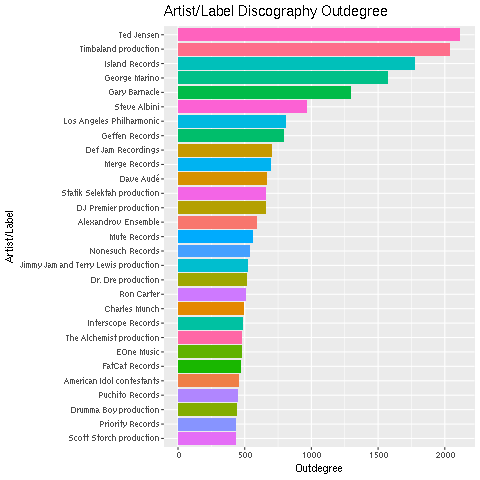

In [78]:
%%R -i disco_df

orig_title <- factor(disco_df$title)
disco_df$title <- gsub(" discography", "", disco_df$title)
    
disco_df$title <- factor(disco_df$title, levels=disco_df$title[order(disco_df$outdeg)])
ggplot(disco_df, aes(x=title, y=outdeg, fill=orig_title)) + geom_bar(stat="identity") +
    coord_flip() + theme(legend.position="") +
    labs(title="Artist/Label Discography Outdegree",
             x= "Artist/Label", y="Outdegree")

... and now I know who [Ted Jensen](https://en.wikipedia.org/wiki/Ted_Jensen) is, the prodigous producer.

## Baseball Roster Analysis

Let's do the same routine for baseball.

In [80]:
bb_outdegs = [x for x in f_y_t_outdegs if re.search("all-time roster", x[0])]
print(len(bb_outdegs))
bb_df = outdeg_to_df(bb_outdegs, 30)

141


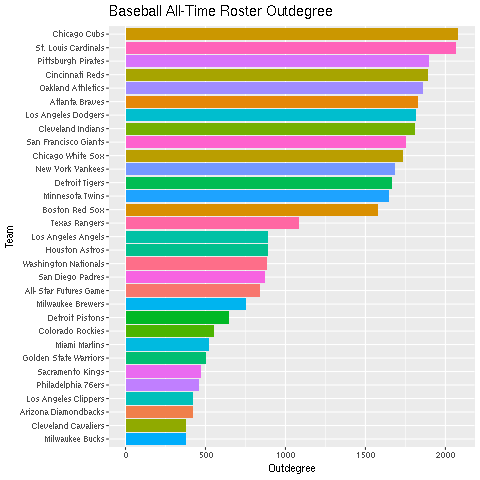

In [81]:
%%R -i bb_df

orig_title <- factor(bb_df$title)
bb_df$title <- gsub(" all-time roster", "", bb_df$title)
    
bb_df$title <- factor(bb_df$title, levels=bb_df$title[order(bb_df$outdeg)])
ggplot(bb_df, aes(x=title, y=outdeg, fill=orig_title)) + geom_bar(stat="identity") +
    coord_flip() + theme(legend.position="") +
    labs(title="Baseball All-Time Roster Outdegree",
             x= "Team", y="Outdegree")

To me, it seems like 14 teams dominate the sport of baseball, and I'm sure this would mean something to a Baseball fan. . Unfortunately, I don't count myself among those folk. But they do seem to like to have voluminous Wikipedia rosters (which makes sense, given their propensity for sabermetrics).

## In-Degree Analysis


In [2]:
from collections import Counter
from functools import reduce

file_list = glob.glob("./PreviousResults/Jan202018/*.dat")

@ray.remote
def collectIndegreeValues(filename):
    f = open(filename)
    
    # This will contain only the lines which are not 
    lines = [re.sub("#.*", "", line.strip()) for line in f if 
             not re.search("https?:\/\/", line) and not re.search(">>>>", line)]
    return(dict(Counter(lines)))

indeg_results_list = ray.get([collectIndegreeValues.remote(filename) for filename in file_list])
len(indeg_results_list)

54

In [3]:
len(indeg_results_list[0])

1426770

In [ ]:
indeg_results = reduce(lambda x,y: Counter(x) + Counter(y), indeg_results_list)

In [ ]:
len(indeg_results)